# Dask

When you have more demanding (as in huge data size or costly algorithm) or complex (as in multiple, often non-linear sequence of steps), you will probably want to:

- make use of all the cores that you have at your disposal locally
- make use of multiple machines in a network
- spare the memory (that may not have enough space to fit the whole problem)
- have tasks that orchestrate themselves in a logical order (dependencies first, then as many parallel jobs as possible/requested).

There are multiple libraries, frameworks or services that meet these needs. In this lecture, we will focus on one of them, [dask](https://dask.org/). It offers (among other features):


- Way to define *directed acyclic graphs* (DAG) of computations tasks;
- Schedulers for local and distibuted parallel computing;
- Distributed arrays and dataframes that follow numpy/pandas API but split the execution of a single function into (potentially many) sub-tasks.


In [34]:
!conda install dask python-graphviz  

# The latter for nice computational graph visualizations

Solving environment: ...working... done

# All requested packages already installed.



## Task graphs

If you want to execute complex computations in the most effective way (regarding CPU power or memory), you must structure them into multiple steps and compose them in a directed acyclic graph. This is something you have been doing the whole time - a sequence of function calls is a (basic) DAG.

![DAG](images/dag.png)

*Image taken from <https://medium.com/kriptapp/guide-what-is-directed-acyclic-graph-364c04662609>*

In reality, often it is the case that the exact order in which the functions (or steps) are executed, is not given. In the example above (each letter represents one function), it is not important whether G is computed before or after A, B or C, also C and D can be computed in any order. This usually means that some of the steps can run in parallel and a clever framework should execute them this way.

### Delayed execution

Everything starts with *delayed* execution of an ordinary function. Python does not offer delayed (or "lazy") evaluation at the syntax level, but luckily, each function is an object and an object can be callable. Dask 
uses this to store both the function to execute and its parameters without executing anything - via the [`delayed`](https://docs.dask.org/en/latest/delayed.html) function:


In [35]:
import numpy as np
from dask import delayed

`delayed` takes as the first parameter any function (for more parameters, read the documentation) and turns it into a function that when called does not execute immediately but returns a prescription for one singular execution of that function:

In [39]:
def square(x):
    return x ** 2

delayed_square = delayed(square)
after_call = delayed_square(4)
after_call

Delayed('square-e7c05baa-1845-42a8-b4c2-6fc82d9a9fff')

You can also use `delayed` as decorator:

In [40]:
@delayed
def cube(x):
    return x ** 3

cube(10)  # Already turned into the lazy version

Delayed('cube-b703ea97-0bd7-4669-a652-c65541d301bc')

When you want to get the result of a delayed call, use the `compute` method. Only then will the computation start and you will obtain the result:

In [45]:
task = cube(np.ones((3, 3)) * 2)
task.compute()

array([[8., 8., 8.],
       [8., 8., 8.],
       [8., 8., 8.]])

The `visualize` method draws the graphical representation of the graph
that leads to a certain delayed computation (trivial in this case, of course):

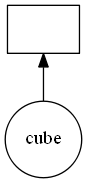

In [46]:
task.visualize()

The fun begins when you start adding more tasks.

A "delayed" object can be used as input for another function (or operator). This means that its result will then be used in the subsequent steps. The following example shows a linear DAG:

[[262144. 262144. 262144.]
 [262144. 262144. 262144.]
 [262144. 262144. 262144.]]


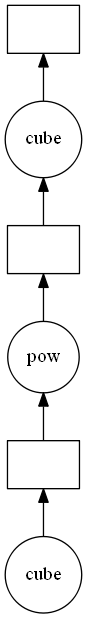

In [52]:
eighteenth_power = cube(square(task))  # [2 ** 3] ** 2 ** 3
print(eighteenth_power.compute())
eighteenth_power.visualize()

Say that we want to compute a complicated polynomial on two arrays.

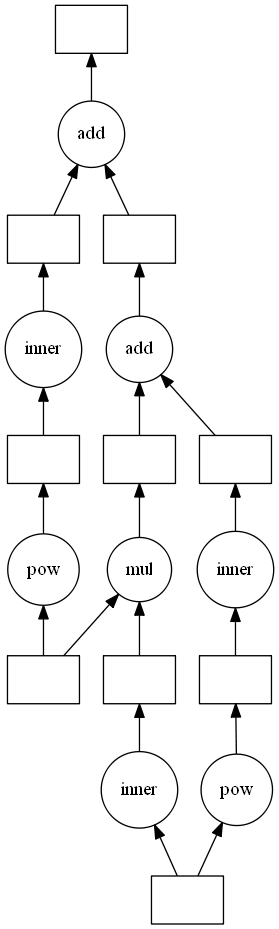

In [57]:
x = delayed(np.random.normal(100000))
y = delayed(np.random.normal(100000, 1, 1))

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2
polynomial.visualize()

Here, you see that the DAG got a bit more complex and that some of its branches are independent of others, and thus can be run in parallel.

In [120]:
A_LOT = 10_000_000

In [121]:
%%timeit

# Normal variant
x = np.random.normal(size=A_LOT)
y = np.random.normal(scale=.5, size=A_LOT)

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2

782 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
%%timeit

# Dask variant
x = delayed(np.random.normal(size=A_LOT))
y = delayed(np.random.normal(scale=.5, size=A_LOT))

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2
polynomial.compute()

729 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not a big gain, right?

Let's make a more complex example (summing the same polynomial for multiple arrays):

In [112]:
def polynomial_f(x, y):
    return 4 * x ** 2 + 24 * x * y + 7 * y ** 2

In [102]:
%%timeit

# Normal variant
total = np.zeros(A_LOT / 10)

for i in range(10):
    x = np.random.normal(size=A_LOT)
    y = np.random.normal(scale=.5, size=A_LOT)
    total += polynomial_f(x, y)
    
total.sum()

7.79 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


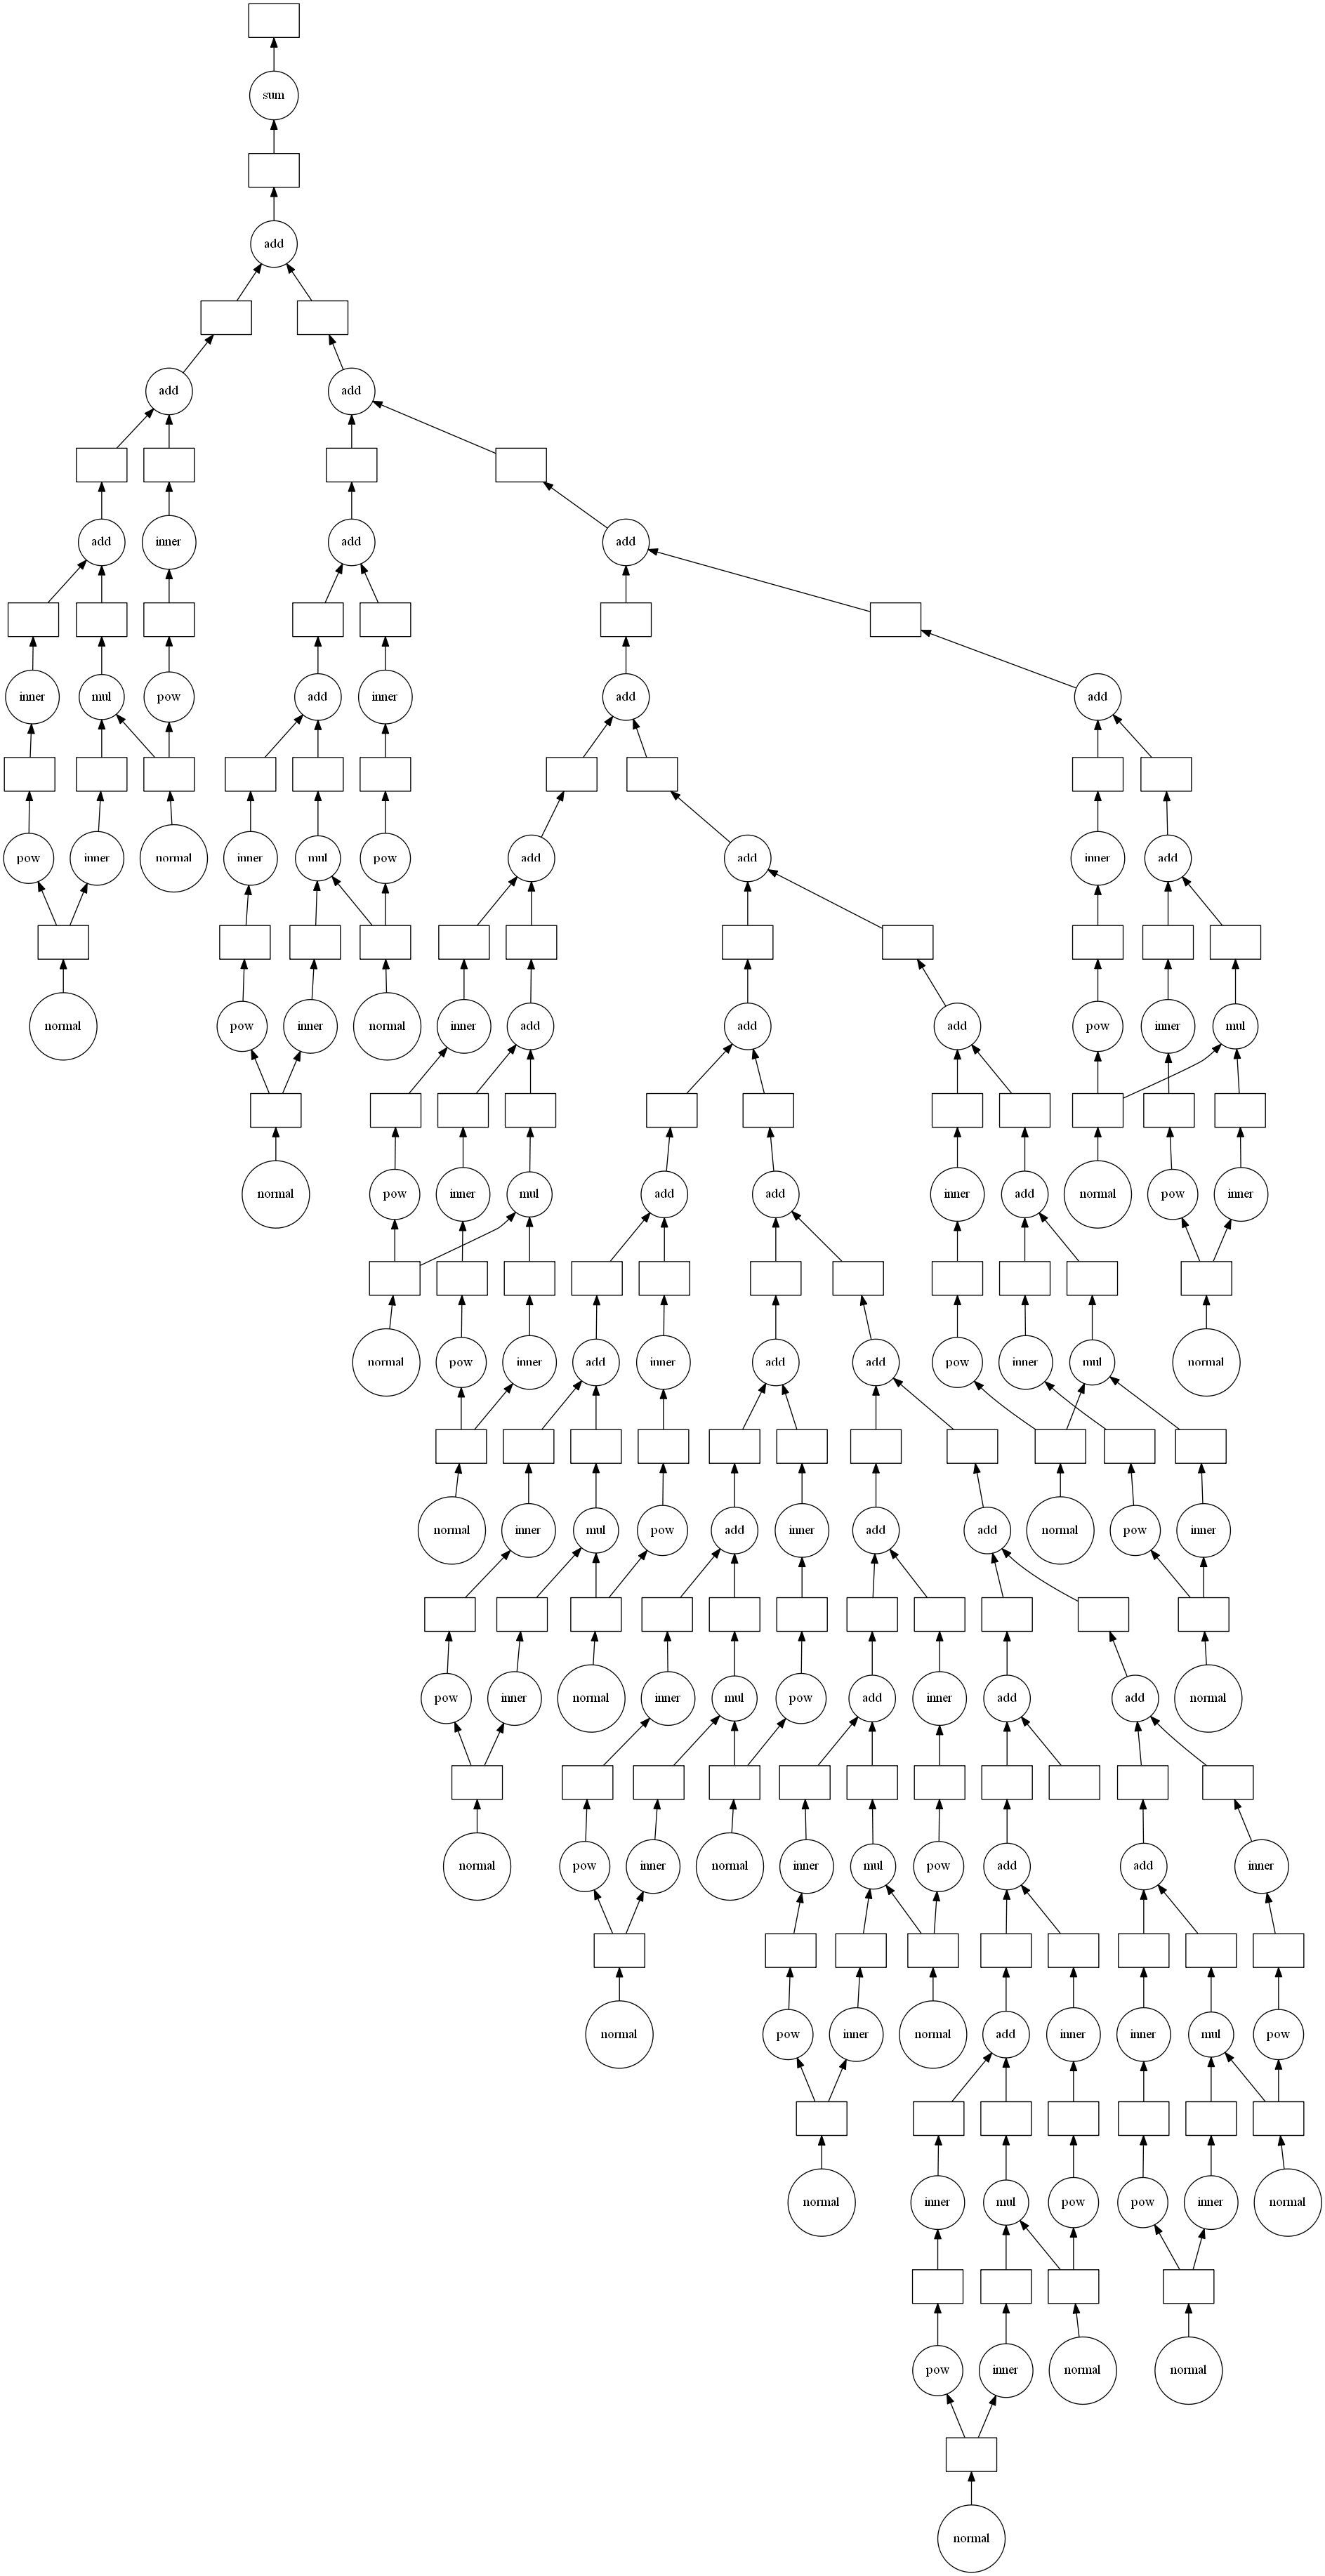

In [114]:
# Dask variant
total = delayed(np.zeros(A_LOT))

for i in range(10):
    x = delayed(np.random.normal)(size=A_LOT)
    y = delayed(np.random.normal)(scale=.5, size=A_LOT)
    total += polynomial_f(x, y)

total.sum().visualize()

Wow! How fast will it execute?

In [115]:
%%timeit
total.sum().compute()

6.17 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Scheduling

In [117]:
%%timeit
import dask.multiprocessing
from multiprocessing.pool import ThreadPool
with dask.config.set(scheduler='threads', pool=ThreadPool(8)):
    total = delayed(np.zeros(A_LOT))

    for i in range(10):
        x = delayed(np.random.normal)(size=A_LOT)
        y = delayed(np.random.normal)(scale=.5, size=A_LOT)
        total += polynomial_f(x, y)

    total.sum().compute()

5.72 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
%%timeit
import dask.multiprocessing

# Dask variant
with dask.config.set(scheduler='processes'):
    total = delayed(np.zeros(A_LOT))

    for i in range(10):
        x = delayed(np.random.normal)(size=A_LOT)
        y = delayed(np.random.normal)(scale=.5, size=A_LOT)
        total += polynomial_f(x, y)

    total.sum().compute()

32.1 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Futures

Dask supports a real-time task framework that extends Python’s `concurrent.futures` interface. This interface is good for arbitrary task scheduling like dask.delayed, but is immediate rather than lazy, which provides some more flexibility in situations where the computations may evolve over time. It is described in the [official documentation](https://docs.dask.org/en/latest/futures.html)

For the futures to start, you need to explicitly start the distributed client (locally or remotely).

In [ ]:
from dask.distributed import Client

client = Client()

client.submit(polynomial_f)

## Parallel data structures





### Dask Array

### Dask DataFrame

## Alternatives

There are many alternatives that each target different aspects of the 

- ray (+ modin)
- pyspark
- joblib
- celery
- luigi
- airflow

## Further reading

